In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import cv2

import torch
import torchvision
from torchvision import models
import torch.nn as nn
from torchvision import transforms,datasets
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset,ConcatDataset
from PIL import Image
import torch.nn.functional as F
from torch.nn.modules.pooling import AvgPool3d
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from itertools import product

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
torch.cuda.is_available()

True

In [3]:
train=pd.read_csv('../input/aerial-cactus-identification/train.csv')
sample=pd.read_csv('../input/aerial-cactus-identification/sample_submission.csv')

In [4]:
train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
id            17500 non-null object
has_cactus    17500 non-null int64
dtypes: int64(1), object(1)
memory usage: 273.6+ KB


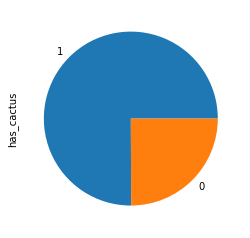

In [6]:
train['has_cactus'].value_counts().plot(kind='pie')

In [7]:
"""extra=train[train.has_cactus==0]
train=pd.concat([train,extra],axis=0)"""

'extra=train[train.has_cactus==0]\ntrain=pd.concat([train,extra],axis=0)'

# Image Transformation

In [8]:
image_transforms={
    'train':transforms.Compose([
        transforms.RandomRotation(degrees=0),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],
                            [0.2,0.2,0.2])]),
    'test':transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],
                            [0.2,0.2,0.2])
    ])
}
        

# Load The Data

In [9]:
train_set,val_set=train_test_split(train,stratify=train.has_cactus,test_size=0.2)

len1=len(train_set)
len2=len(val_set)

# Loading Data From Folders
train_dir='train/train'
test_dir='test/test'

In [10]:
class dataset_(torch.utils.data.Dataset):
    def __init__(self,labels,data_directory,transform):
        super().__init__()

        #characterizes a dataset for Pytorch
        
        self.list_id=labels.values[:,0]
        self.labels=labels.values[:,1]
        self.data_dir=data_directory
        self.transform=transform
    
    def __len__(self):
        # Denotes the tota number of samples
        return len(self.list_id)
    
    def __getitem__(self,index):
        name=self.list_id[index]
        img=Image.open('../input/aerial-cactus-identification/{}/{}'.format(self.data_dir,name))
        img=self.transform(img)
        return img,torch.tensor(self.labels[index],dtype=torch.float32)

In [11]:
train_set=dataset_(train_set,train_dir,image_transforms['train'])
#train_df=DataLoader(train_df,batch_size=120,shuffle=True)

val_set=dataset_(val_set,train_dir,image_transforms['test'])
#val_df=DataLoader(val_df,batch_size=120,shuffle=True)

In [12]:
#test=dataset_(ter)

In [13]:
lst,labels=next(iter(train_set))

In [14]:
lst.shape,labels.shape,labels

(torch.Size([3, 32, 32]), torch.Size([]), tensor(1.))

# Creating A Model

In [15]:
def size(image_size,ker,stri,pad=0):
    return (image_size-ker+2*pad)/stri +1

In [16]:
size(8,2,2)

4.0

In [17]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.dense_1=nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3, padding=1)
        self.dense_2=nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels= 64,kernel_size= 3, padding=1)
        self.dense_3=nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(in_channels=64,out_channels= 128,kernel_size= 3, padding=1)
        self.dense_4=nn.BatchNorm2d(128)
        
        # Linear layer
        self.fc1 = nn.Linear(in_features=128*2*2,out_features= 128)
        self.fc_dense1=nn.BatchNorm1d(128)
        self.out = nn.Linear(in_features=128,out_features=2)
        # Set Dropout
        self.d1 = nn.Dropout(0.5)
        self.f=nn.Sigmoid()


    def forward(self,t):
        #input layer
        t=t
        #first convolutional layer
        t=F.max_pool2d(F.leaky_relu(self.dense_1(self.conv1(t))),kernel_size=2,stride=2)
        
        #Second Convolutional Layer
        
        t=F.max_pool2d(F.leaky_relu(self.dense_2(self.conv2(t))),stride=2,kernel_size=2)
        
        #Third Convolution Layer
        
        t=F.max_pool2d(F.leaky_relu(self.dense_3(self.conv3(t))),stride=2,kernel_size=2)
        
        # Fourth Convolutional Layer
        t=F.max_pool2d(F.leaky_relu(self.dense_4(self.conv4(t))),stride=2,kernel_size=2)
        
        # First linear Layer
        t=t.reshape(-1,128*2*2)
        t=F.leaky_relu(self.fc_dense1(self.fc1(t)))
        t=self.d1(t)
        
        #Second Linear Layer
        t=self.f(self.out(t))
        return t

# Training Process

In [18]:
batch_sizes=120
lrs=0.2
train_loss=[]
val_loss=[]
train_correct=[]
val_correct=[]
epoch=[]
model=Model()
model=model.to('cuda:0')
optimizer=optim.SGD(model.parameters(),lr=lrs)

train_df=DataLoader(train_set,batch_size=batch_sizes,shuffle=True)
val_df=DataLoader(val_set,batch_size=batch_sizes,shuffle=True)

for i in range(30):
    total_loss=0 # Total loss for an epoch
    total_correct=0 #Total correct number of predictions
    for batch in train_df:
        images,labels=batch #loading a batch

        images=images.to('cuda:0') #changing the device
        labels=labels.to('cuda:0') 
        #changing data type
        labels=labels.long()
        preds=model(images) #passing the images batch through the model
        
        #f=nn.Softmax()
        #preds=f(preds)
        loss=F.cross_entropy(preds,labels) #CALCULATING lOSS
            
        
        #Setting the last gradient matrix to zero
        optimizer.zero_grad()

        loss.backward() # Calculating the gradient
        optimizer.step()# Updating the parameters
        total_loss+=loss.item() # calculating the total loss 
        total_correct+=preds.argmax(dim=1).eq(labels).sum().item()#Calculating the correct prediction in a single epoch
        del images,labels # 
        
    train_loss.append(total_loss)
    train_correct.append(total_correct/len1)
    epoch.append(i+1)

    with torch.no_grad():
        total_val_loss=0
        total_val_correct=0
        for val_batch in val_df:
            val_im,val_lab=val_batch
            val_im=val_im.to('cuda:0')
            val_lab=val_lab.to('cuda:0')
            val_lab=val_lab.long()
            
            val_preds=model(val_im)
            
            
            loss_val=F.cross_entropy(val_preds,val_lab)
            total_val_loss+=loss_val
            total_val_correct+=val_preds.argmax(dim=1).eq(val_lab).sum().item()

        val_loss.append(total_val_loss)
        val_correct.append(total_val_correct/len2)

        print("Epoch {}\t train_loss {}\t train_accuracy{}\t val_loss {}\t val_accuracy {}\n".format(epoch[i],total_loss,
                                                                                                     total_correct/len1,total_val_loss,total_val_correct/len2))

Epoch 1	 train_loss 46.07781466841698	 train_accuracy0.9385	 val_loss 10.864930152893066	 val_accuracy 0.9565714285714285

Epoch 2	 train_loss 40.648639261722565	 train_accuracy0.9710714285714286	 val_loss 10.36539077758789	 val_accuracy 0.9691428571428572

Epoch 3	 train_loss 39.918592154979706	 train_accuracy0.9741428571428571	 val_loss 10.105219841003418	 val_accuracy 0.9802857142857143

Epoch 4	 train_loss 39.269927740097046	 train_accuracy0.9803571428571428	 val_loss 10.135581016540527	 val_accuracy 0.9782857142857143

Epoch 5	 train_loss 38.5318489074707	 train_accuracy0.9861428571428571	 val_loss 9.976747512817383	 val_accuracy 0.9834285714285714

Epoch 6	 train_loss 38.43722125887871	 train_accuracy0.9865714285714285	 val_loss 9.818750381469727	 val_accuracy 0.9882857142857143

Epoch 7	 train_loss 38.21833336353302	 train_accuracy0.9880714285714286	 val_loss 9.867711067199707	 val_accuracy 0.9842857142857143

Epoch 8	 train_loss 37.98242139816284	 train_accuracy0.99	 val_loss 9

ValueError: x and y must have same first dimension, but have shapes (29,) and (30,)

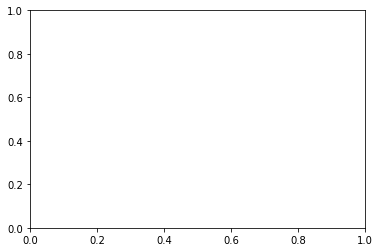

In [19]:
ep=[i for i in range(1,30)]
plt.plot(ep,train_loss,label='train')
plt.plot(ep,val_loss,label='test')
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (29,) and (30,)

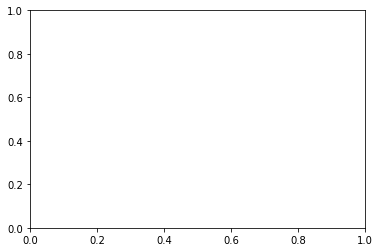

In [20]:
plt.plot(ep,train_correct,label='train',color='magenta')
plt.plot(ep,val_correct,label='test',color='royalblue')
plt.legend()

In [21]:
class dataset_(torch.utils.data.Dataset):
    def __init__(self,data_directory,transform):
        super().__init__()

        #characterizes a dataset for Pytorch
        self.list_id=os.listdir("../input/aerial-cactus-identification/test/test")
        self.labels=[0]*len(self.list_id)
        self.data_dir=data_directory
        self.transform=transform
    
    def __len__(self):
        # Denotes the tota number of samples
        return len(self.list_id)
    
    def __getitem__(self,index):
        name=self.list_id[index]
        img=Image.open('{}/{}'.format(self.data_dir,name))
        img=self.transform(img)
        return img,torch.tensor(self.labels[index],dtype=torch.float32)

In [22]:
test=dataset_("../input/aerial-cactus-identification/test/test",image_transforms['test'])
test=DataLoader(test,batch_size=batch_sizes)

In [23]:
name=os.listdir("../input/aerial-cactus-identification/test/test")
label=[]
with torch.no_grad():
    for test_batch in test:
        test_img,test_lab=test_batch
        test_img,test_lab=test_img.to('cuda:0'),test_lab.to('cuda:0')
        test_lab=model(test_img)
        test_lab=torch.max(test_lab,dim=1)
        #test_lab=test_lab.cpu().tolist()
        test_predict=[]
        for i in range(test_lab[0].shape[0]):
            if test_lab[1][i]==0:
                test_predict.append(1-test_lab[0][i].item())
            else:
                test_predict.append(test_lab[0][i].item())
        label=label+test_predict

In [24]:
submissions=pd.DataFrame({"id":name,"has_cactus":label})

In [25]:
submissions.to_csv('samplesubmission.csv',index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 